In [47]:
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers

In [68]:
class Sampling(layers.Layer):
  def call(self, inputs):
    z_mean, z_log_var = inputs
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [69]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 14, 14, 32)   320         input_15[0][0]                   
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 7, 7, 64)     18496       conv2d_12[0][0]                  
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 3136)         0           conv2d_13[0][0]                  
____________________________________________________________________________________________

In [70]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 2)]               0         
_________________________________________________________________
dense_13 (Dense)             (None, 3136)              9408      
_________________________________________________________________
reshape_9 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose_18 (Conv2DT (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_19 (Conv2DT (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_transpose_20 (Conv2DT (None, 28, 28, 1)         289       
Total params: 65,089
Trainable params: 65,089
Non-trainable params: 0
_______________________________________________________

In [71]:
class VAE(keras.Model):
  def __init__(self, encoder, decoder, **kwargs):
    super(VAE, self).__init__(**kwargs)
    self.encoder = encoder
    self.decoder = decoder
    self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
    self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
    self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

  
  @property
  def metrics(self):
    return [self.total_loss_tracker, self.reconstruction_loss_tracker, self.kl_loss_tracker,]

  def train_step(self, data):
    with tf.GradientTape() as tape:
      z_mean, z_log_var, z = self.encoder(data)
      reconstruction = self.decoder(z)
      reconstruction_loss = tf.reduce_mean(tf.reduce_sum(keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)))
      kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
      kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
      total_loss = reconstruction_loss + kl_loss
      grads = tape.gradient(total_loss, self.trainable_weights)
    self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
    self.total_loss_tracker.update_state(total_loss)
    self.reconstruction_loss_tracker.update_state(reconstruction_loss)
    self.kl_loss_tracker.update_state(kl_loss)
    return {"loss": self.total_loss_tracker.result(), "reconstruction_loss": self.reconstruction_loss_tracker.result(), "kl_loss": self.kl_loss_tracker.result(),}

In [72]:
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(mnist_digits, epochs=30, batch_size=128)

Epoch 1/30
547/547 [==============================] - 97s 176ms/step - loss: 252.7015 - reconstruction_loss: 205.8570 - kl_loss: 3.3728
Epoch 2/30
547/547 [==============================] - 96s 176ms/step - loss: 177.0545 - reconstruction_loss: 167.3070 - kl_loss: 5.8793
Epoch 3/30
547/547 [==============================] - 97s 176ms/step - loss: 167.2131 - reconstruction_loss: 159.8873 - kl_loss: 6.2791
Epoch 4/30
547/547 [==============================] - 96s 176ms/step - loss: 163.8409 - reconstruction_loss: 156.6261 - kl_loss: 6.4889
Epoch 5/30
547/547 [==============================] - 97s 177ms/step - loss: 161.3783 - reconstruction_loss: 154.4797 - kl_loss: 6.5751
Epoch 6/30
547/547 [==============================] - 97s 177ms/step - loss: 159.6560 - reconstruction_loss: 153.0462 - kl_loss: 6.6034
Epoch 7/30
547/547 [==============================] - 97s 177ms/step - loss: 159.0805 - reconstruction_loss: 151.9081 - kl_loss: 6.6131
Epoch 8/30
547/547 [============================

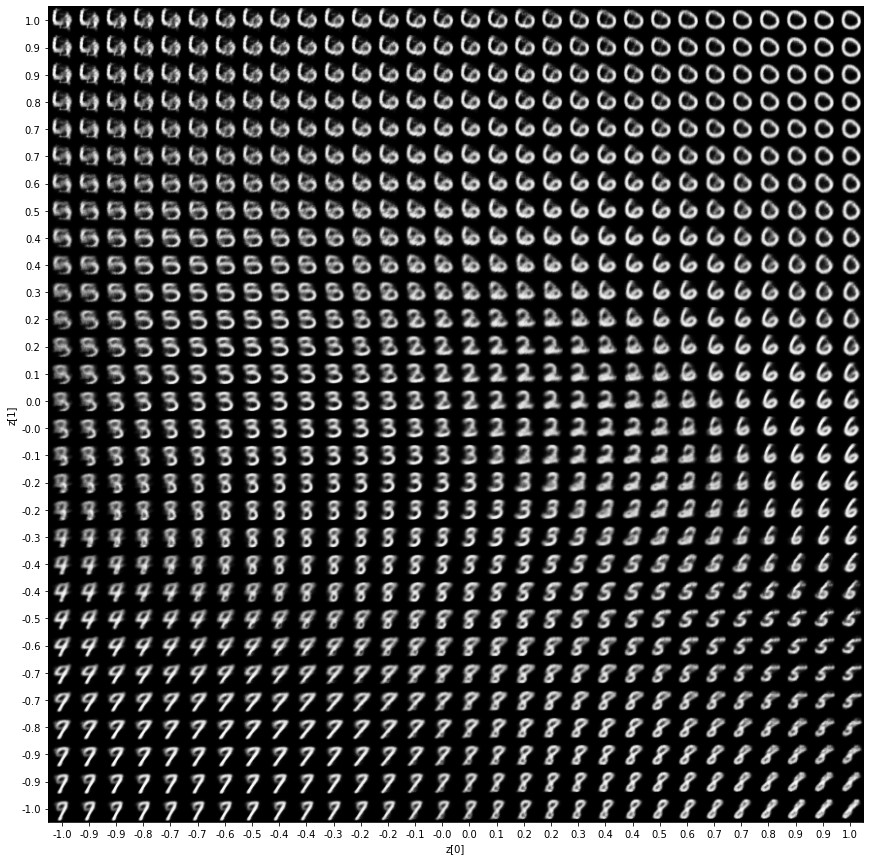

In [73]:
def plot_latent_space(vae, n=30, figsize=15):
  # display a n*n 2D manifold of digits
  digit_size = 28
  scale = 1.0
  figure = np.zeros((digit_size * n, digit_size * n))
  # linearly spaced coordinates corresponding to the 2D plot
  # of digit classes in the latent space
  grid_x = np.linspace(-scale, scale, n)
  grid_y = np.linspace(-scale, scale, n)[::-1]

  for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
      z_sample = np.array([[xi, yi]])
      x_decoded = vae.decoder.predict(z_sample)
      digit = x_decoded[0].reshape(digit_size, digit_size)
      figure[i * digit_size : (i + 1) * digit_size, j * digit_size : (j + 1) * digit_size,] = digit

  plt.figure(figsize=(figsize, figsize))
  start_range = digit_size // 2
  end_range = n * digit_size + start_range
  pixel_range = np.arange(start_range, end_range, digit_size)
  sample_range_x = np.round(grid_x, 1)
  sample_range_y = np.round(grid_y, 1)
  plt.xticks(pixel_range, sample_range_x)
  plt.yticks(pixel_range, sample_range_y)
  plt.xlabel("z[0]")
  plt.ylabel("z[1]")
  plt.imshow(figure, cmap="Greys_r")
  plt.show()


plot_latent_space(vae)

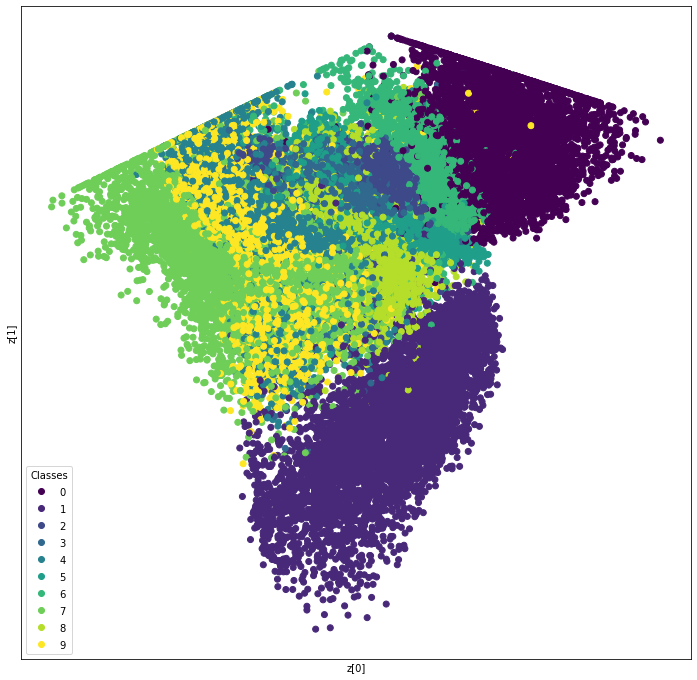

In [76]:
def plot_label_clusters(vae, data, labels):
  z_mean, _, _ = vae.encoder.predict(data)
  plt.figure(figsize=(12, 12))
  scatter = plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
  plt.xlabel("z[0]")
  plt.ylabel("z[1]")
  plt.legend(*scatter.legend_elements(), loc="lower left", title = "Classes")
  plt.xticks([])
  plt.yticks([])
  plt.show()


(x_train, y_train), _ = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

plot_label_clusters(vae, x_train, y_train)